1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

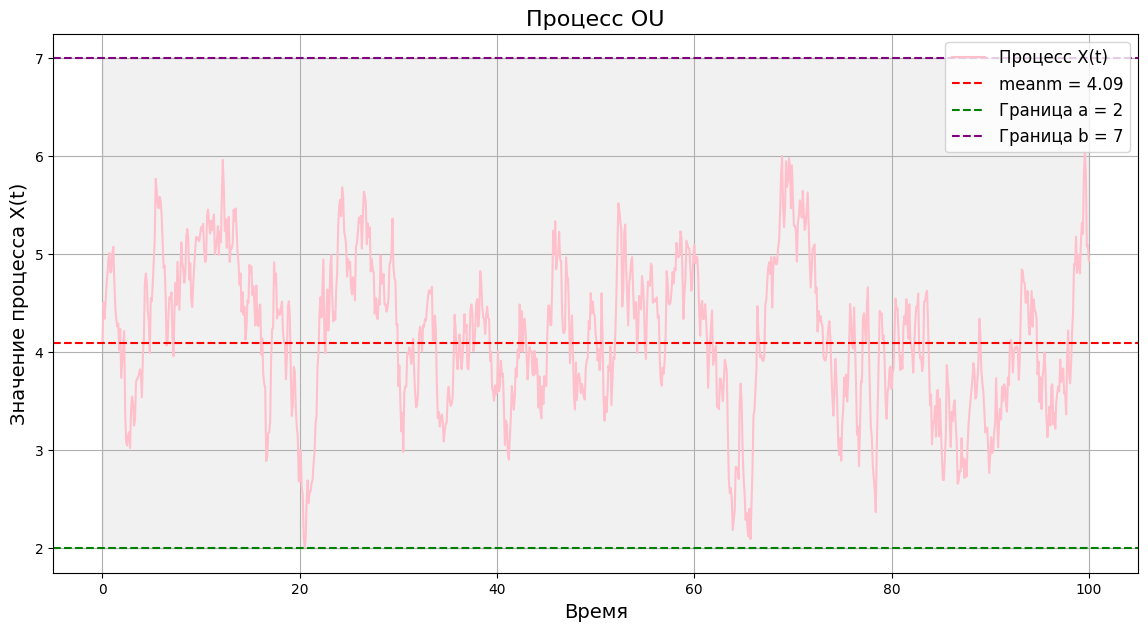

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
a = 2
b = 7
dt = 0.1     # Шаг времени
N = 1000     # Количество шагов
theta_0 = 0.5  # Базовая скорость возврата к среднему
sigma_0 = 1    # Базовая волатильность

# Выбираем c из равномерного распределения U(a, b)
c = np.random.uniform(a, b)

# Определяем m так, чтобы он находился в пределах [a, b]
m = b - (c - a)

# Вычисляем фактор расстояния
midpoint = (a + b) / 2
distance_factor = abs(m - midpoint) / ((b - a) / 2)

# Корректируем theta и sigma на основе значения m
theta = theta_0 * (1 + distance_factor)
sigma = sigma_0 * (1 - distance_factor)

# Убедимся, что sigma неотрицательна
sigma = max(sigma, 0.1)

# Инициализация процесса
X = np.zeros(N + 1)
X[0] = m  # Начинаем с уровня возврата к среднему

for t in range(1, N + 1):
    epsilon = np.random.normal()
    X_t = X[t - 1] + theta * (m - X[t - 1]) * dt + sigma * np.sqrt(dt) * epsilon

    # Отражающие границы
    if X_t < a:
        X_t = a + (a - X_t)
    elif X_t > b:
        X_t = b - (X_t - b)
    X[t] = X_t


time = np.linspace(0, N * dt, N + 1)
plt.figure(figsize=(14, 7))
plt.plot(time, X, label='Процесс X(t)', color='pink')
plt.axhline(y=m, color='red', linestyle='--', label=f'meanm = {m:.2f}')
plt.axhline(y=a, color='green', linestyle='--', label=f'Граница a = {a}')
plt.axhline(y=b, color='purple', linestyle='--', label=f'Граница b = {b}')
plt.fill_between(time, a, b, color='lightgrey', alpha=0.3)
plt.title('Процесс OU', fontsize=16)
plt.xlabel('Время', fontsize=14)
plt.ylabel('Значение процесса X(t)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

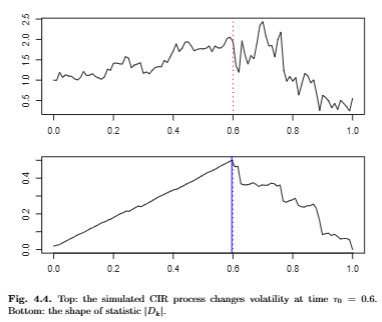

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

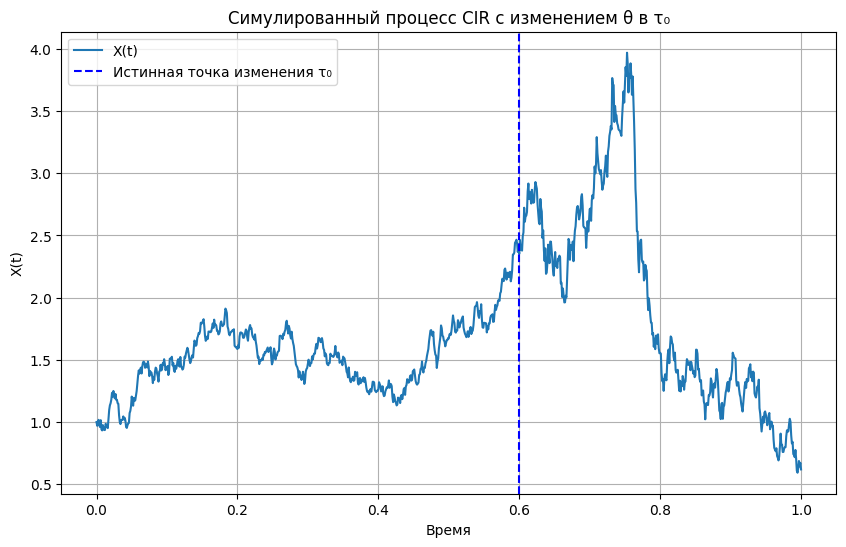

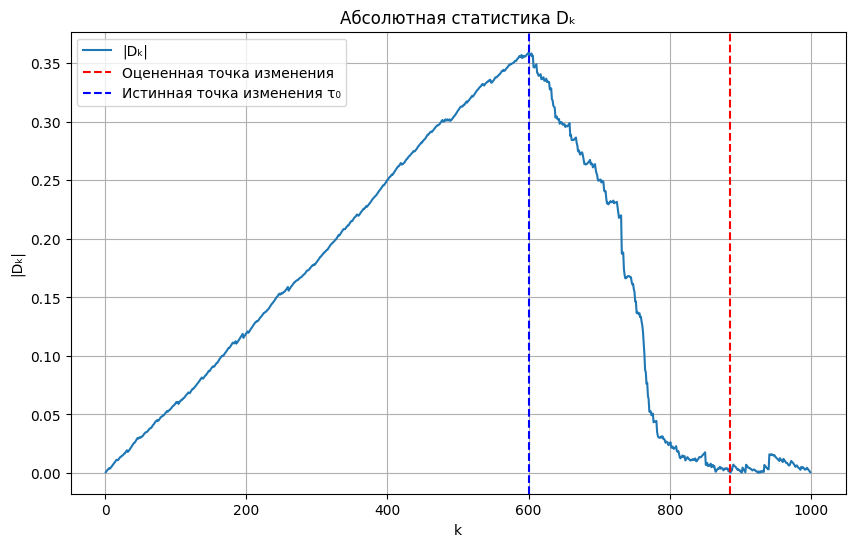

Оцененная точка изменения k̂₀: 885 во времени 0.885
Истинная точка изменения во времени τ₀: 0.6 соответствует k = 600


In [37]:
np.random.seed(123)
alpha = 6
beta = 2
theta1 = 1
theta2 = 2
tau0 = 0.6
n = 1000
delta_n = 1 / n
t = np.linspace(0, 1, n + 1)  # Вектор времени от t_0 до t_n

# Инициализировать X
X = np.zeros(n + 1)
X[0] = 1  # Начальное значение X(0) = 1

# Симулировать приращения броуновского движения
delta_W = np.random.normal(0, np.sqrt(delta_n), n)

# Симулировать процесс CIR с изменением theta
for i in range(n):
    theta = theta1 if t[i] < tau0 else theta2
    X_i_plus = max(X[i], 0)
    X[i + 1] = X[i] + (alpha - beta * X_i_plus) * delta_n + theta * np.sqrt(X_i_plus) * delta_W[i]
    X[i + 1] = max(X[i + 1], 0)  

plt.figure(figsize=(10, 6))
plt.plot(t, X, label='X(t)')
plt.axvline(x=tau0, color='blue', linestyle='--', label='Истинная точка изменения τ₀')
plt.title('Симулированный процесс CIR с изменением θ в τ₀')
plt.xlabel('Время')
plt.ylabel('X(t)')
plt.legend()
plt.grid(True)
plt.show()

# Ядерная оценка b(x)
h_n = 0.05  # Ширина окна

def K(u):
    """Функция ядра Эпанечникова."""
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

# Оценить b_hat в каждой точке X_i
b_hat = np.zeros(n)

for i in range(n):
    X_i = X[i]
    distances = X[:n] - X_i
    mask = np.abs(distances) <= h_n
    indices = np.where(mask)[0]
    if len(indices) == 0:
        b_hat[i] = 0
    else:
        weights = K(distances[indices] / h_n)
        numerator = np.sum(weights * (X[indices + 1] - X[indices]))
        denominator = delta_n * np.sum(weights)
        if denominator != 0:
            b_hat[i] = numerator / denominator
        else:
            b_hat[i] = 0

# Вычислить остатки Z_i
Z = ((X[1:n + 1] - X[:n]) - b_hat * delta_n) / np.sqrt(delta_n)

# Вычислить кумулятивные суммы S_k
S_n = np.sum(Z**2)
S_k = np.cumsum(Z**2)

# Вычислить D_k
k_seq = np.arange(1, n)
D_k = (k_seq / n) - (S_k[k_seq - 1] / S_n)
abs_D_k = np.abs(D_k)

# Найти k_hat0
k_hat0 = np.argmin(abs_D_k)
tau_hat0 = t[k_hat0]

plt.figure(figsize=(10, 6))
plt.plot(k_seq, abs_D_k, label='|Dₖ|')
plt.axvline(x=k_hat0, color='red', linestyle='--', label='Оцененная точка изменения')
plt.axvline(x=int(tau0 * n), color='blue', linestyle='--', label='Истинная точка изменения τ₀')
plt.title('Абсолютная статистика Dₖ')
plt.xlabel('k')
plt.ylabel('|Dₖ|')
plt.legend()
plt.grid(True)
plt.show()

print('Оцененная точка изменения k̂₀:', k_hat0, 'во времени', round(tau_hat0, 4))
print('Истинная точка изменения во времени τ₀:', tau0, 'соответствует k =', int(tau0 * n))

3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

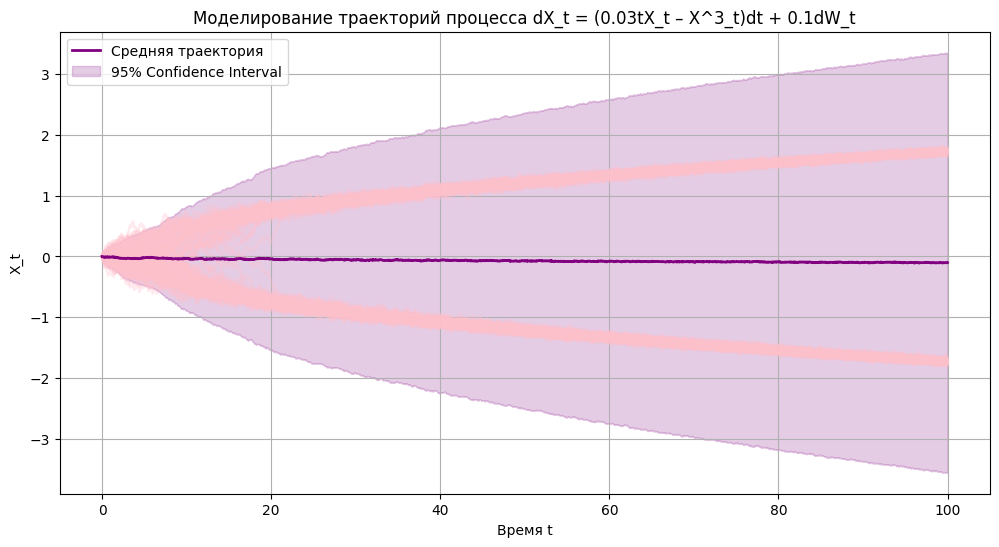

In [70]:
num_trajectories = 100  # количество траекторий
x0 = 0  # начальное значение X_0
t0 = 0  # начальное время
T = 100  # конечное время
dt = 0.01  # шаг по времени Δt
N = int((T - t0) / dt)  # количество временных шагов
t = np.linspace(t0, T, N+1)  # массив временных точек

# Определяем функции для дрейфа и диффузии
def drift(x, t):
    return 0.03 * t * x - x**3  # функция дрейфа a(x, t)

def diffusion(x, t):
    return 0.1  # функция диффузии b(x, t)

# Инициализируем массив для хранения всех траекторий
X = np.zeros((num_trajectories, N+1))


for i in range(num_trajectories):
    X_i = x0  # начальное значение для i-й траектории
    X[i, 0] = X_i
    for n in range(N):
        t_n = t[n]
        # Генерируем приращение Винеровского процесса
        dW = np.sqrt(dt) * np.random.randn()
        # Вычисляем следующее значение X по схеме Милстейна
        X_i += drift(X_i, t_n) * dt + diffusion(X_i, t_n) * dW
        # Сохраняем значение в массиве
        X[i, n+1] = X_i

# Рассчитываем среднюю траекторию и доверительный интервал
X_mean = np.mean(X, axis=0)  # среднее значение в каждый момент времени
X_std = np.std(X, axis=0)  # стандартное отклонение в каждый момент времени
confidence_interval = 1.96 * X_std / np.sqrt(num_trajectories)  # 95% доверительный интервал


plt.figure(figsize=(12, 6))

# Рисуем все траектории
for i in range(num_trajectories):
    plt.plot(t, X[i], color='pink', alpha=0.3)


plt.plot(t, X_mean, color='purple', linewidth=2, label='Средняя траектория')
#plt.fill_between(t, X_mean - confidence_interval, X_mean + confidence_interval, color='blue', alpha=0.2, label='95% доверительный интервал')
plt.fill_between(t, X_mean - 2*X_std, X_mean + 2*X_std, color='purple', alpha=0.2, label='95% Confidence Interval')
plt.title('Моделирование траекторий процесса dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t')
plt.xlabel('Время t')
plt.ylabel('X_t')
plt.legend()
plt.grid(True)
plt.show()

4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


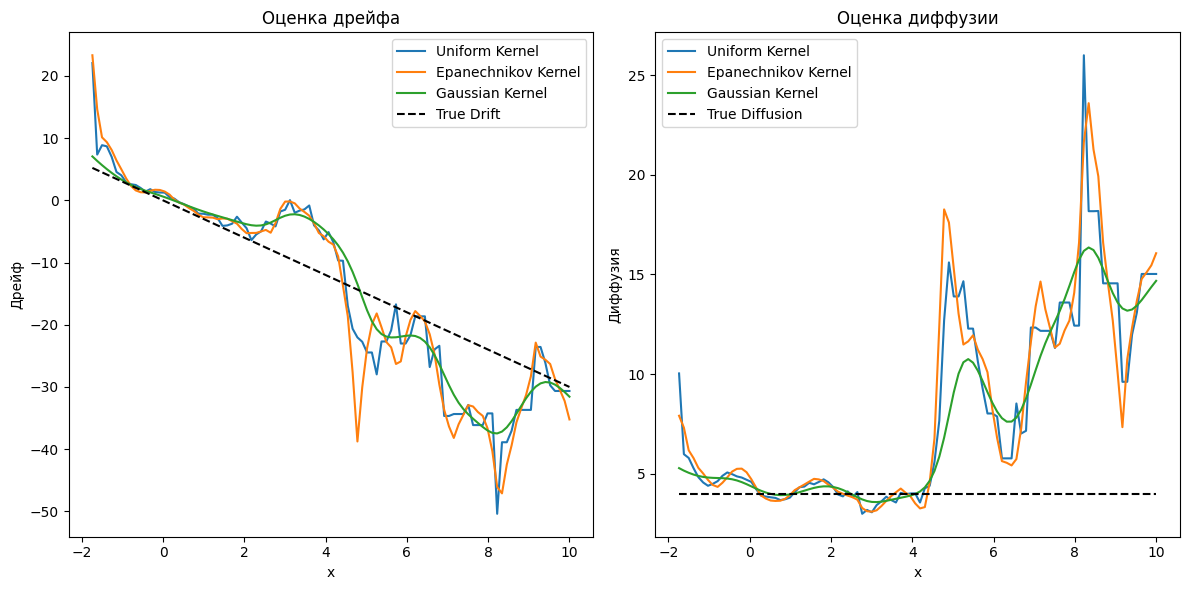

In [66]:
from scipy.stats import norm


theta1 = 0       
theta2 = 3       
theta3 = 2       
X0 = 10          # Начальное значение X(0)
T = 10           # Конечное время
dt = 0.01        # Шаг по времени
N = int(T / dt)  # Количество шагов
t = np.linspace(0, T, N)  # Массив времени

# Инициализируем массив для хранения значений процесса
X = np.zeros(N)
X[0] = X0

# Генерируем случайные числа для моделирования винеровского процесса
dW = np.sqrt(dt) * np.random.randn(N - 1)

# Симулируем процесс Орнштейна-Уленбека с помощью метода Эйлера
for i in range(1, N):
    X[i] = X[i - 1] + (theta1 - theta2 * X[i - 1]) * dt + theta3 * dW[i - 1]

# Определяем ядра
def uniform_kernel(u):
    return 0.5 * np.ones_like(u) * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

# Задаем ширину окна (параметр сглаживания)
h = 0.5

# Создаем сетку значений x для оценки
x_grid = np.linspace(min(X), max(X), 100)

# Функция для оценки дрейфа и диффузии
def estimate_drift_diffusion(X, dt, x_grid, kernel):
    # Вычисляем приращения процесса
    dX = np.diff(X)
    X_mid = X[:-1]  # Значения X_t

    # Инициализируем массивы для хранения оценок
    drift_est = np.zeros_like(x_grid)
    diffusion_est = np.zeros_like(x_grid)

    for i, x in enumerate(x_grid):
        # Вычисляем веса с помощью ядра
        u = (X_mid - x) / h
        weights = kernel(u)

        # Избегаем деления на ноль
        if np.sum(weights) > 0:
            # Нормируем веса
            K = weights / np.sum(weights)

            # Оцениваем дрейф
            drift_est[i] = np.sum(K * dX) / dt

            # Оцениваем диффузию
            diffusion_est[i] = np.sum(K * (dX)**2) / dt
        else:
            drift_est[i] = np.nan
            diffusion_est[i] = np.nan

    return drift_est, diffusion_est

# Оцениваем дрейф и диффузию для каждого ядра
drift_uniform, diffusion_uniform = estimate_drift_diffusion(X, dt, x_grid, uniform_kernel)
drift_epanechnikov, diffusion_epanechnikov = estimate_drift_diffusion(X, dt, x_grid, epanechnikov_kernel)
drift_gaussian, diffusion_gaussian = estimate_drift_diffusion(X, dt, x_grid, gaussian_kernel)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Оценка дрейфа')
plt.plot(x_grid, drift_uniform, label='Uniform Kernel')
plt.plot(x_grid, drift_epanechnikov, label='Epanechnikov Kernel')
plt.plot(x_grid, drift_gaussian, label='Gaussian Kernel')
plt.plot(x_grid, -theta2 * x_grid, 'k--', label='True Drift')
plt.xlabel('x')
plt.ylabel('Дрейф')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Оценка диффузии')
plt.plot(x_grid, diffusion_uniform, label='Uniform Kernel')
plt.plot(x_grid, diffusion_epanechnikov, label='Epanechnikov Kernel')
plt.plot(x_grid, diffusion_gaussian, label='Gaussian Kernel')
plt.plot(x_grid, np.full_like(x_grid, theta3**2), 'k--', label='True Diffusion')
plt.xlabel('x')
plt.ylabel('Диффузия')
plt.legend()

plt.tight_layout()
plt.show()

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

In [59]:
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('9.csv')
data = pd.DataFrame({'Time': data['Unnamed: 0'], 'Price': data['0']}) 
#time = data['Time']
#values = data['Price']

In [48]:
data

,Time,Price
0,0.000000,0.500000
1,0.003333,0.464510
2,0.006667,0.498279
3,0.010000,0.505815
4,0.013333,0.565688
...,...,...
296,0.986667,1.849100
297,0.990000,1.778978
298,0.993333,1.729205
299,0.996667,1.678159


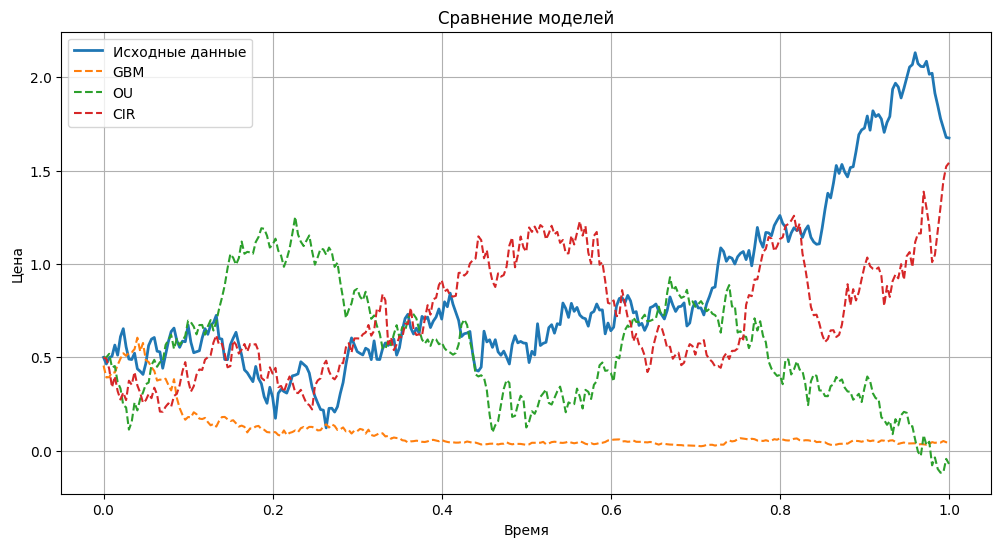

MSE GBM: 0.7903
MSE OU: 0.5488
MSE CIR: 0.1702

Лучшая модель: CIR

Результат теста Дики-Фуллера:
ADF Statistic: -0.4036
p-value: 0.9095


In [61]:
N = len(data['Time'])  
dt = 1/N  
S0 = data['Price'][0]  # начальная цена
mu_true = 0.05  # истинный дрейф
sigma_true = 0.2  # истинная волатильность


# Функция для оценки параметров GBM
def estimate_gbm_params(S):
    log_returns = np.log(S[1:].values / S[:-1].values)
    mu_hat = np.mean(log_returns) / dt
    sigma_hat = np.std(log_returns) / np.sqrt(dt)
    return mu_hat, sigma_hat

# Функция для оценки параметров OU
def estimate_ou_params(X):
    delta_X = np.diff(X)
    X_t = X[:-1]
    dt_array = np.full_like(X_t, dt)

    # Регрессия delta_X = theta*(mu - X_t)*dt + sigma*dW
    def ou_neg_log_likelihood(params):
        theta, mu, sigma = params
        residuals = delta_X - theta * (mu - X_t) * dt
        likelihoods = -0.5 * np.log(2 * np.pi * sigma**2 * dt) - (residuals**2) / (2 * sigma**2 * dt)
        return -np.sum(likelihoods)

    initial_guess = [1.0, np.mean(X), np.std(delta_X)]
    bounds = [(1e-5, None), (None, None), (1e-5, None)]
    result = minimize(ou_neg_log_likelihood, initial_guess, bounds=bounds)
    theta_hat, mu_hat, sigma_hat = result.x
    return theta_hat, mu_hat, sigma_hat

# Функция для оценки параметров CIR
def estimate_cir_params(X):
    delta_X = np.diff(X)
    X_t = X[:-1]
    dt_array = np.full_like(X_t, dt)

    # Логарифм правдоподобия для процесса CIR
    def cir_neg_log_likelihood(params):
        theta, mu, sigma = params
        residuals = delta_X - theta * (mu - X_t) * dt
        variances = sigma**2 * X_t * dt
        likelihoods = -0.5 * np.log(2 * np.pi * variances) - (residuals**2) / (2 * variances)
        return -np.sum(likelihoods)

    initial_guess = [1.0, np.mean(X), 0.1]
    bounds = [(1e-5, None), (1e-5, None), (1e-5, None)]
    result = minimize(cir_neg_log_likelihood, initial_guess, bounds=bounds)
    theta_hat, mu_hat, sigma_hat = result.x
    return theta_hat, mu_hat, sigma_hat

# Оценка параметров для каждой модели
mu_gbm, sigma_gbm = estimate_gbm_params(data['Price'])
theta_ou, mu_ou, sigma_ou = estimate_ou_params(data['Price'])
theta_cir, mu_cir, sigma_cir = estimate_cir_params(data['Price'])

# Симуляция каждого процесса с оцененными параметрами
def simulate_gbm(S0, mu, sigma, N, dt):
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)
    time = np.linspace(0, N*dt, N)
    S = S0 * np.exp((mu - 0.5 * sigma**2) * time + sigma * W)
    return S

def simulate_ou(X0, theta, mu, sigma, N, dt):
    X = np.zeros(N)
    X[0] = X0
    for t in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * dW
    return X

def simulate_cir(X0, theta, mu, sigma, N, dt):
    X = np.zeros(N)
    X[0] = X0
    for t in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * np.sqrt(abs(X[t-1])) * dW
        # Обеспечение неотрицательности
        X[t] = max(X[t], 0)
    return X


S_gbm = simulate_gbm(S0, mu_gbm, sigma_gbm, N, dt)
S_ou = simulate_ou(S0, theta_ou, mu_ou, sigma_ou, N, dt)
S_cir = simulate_cir(S0, theta_cir, mu_cir, sigma_cir, N, dt)


plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['Price'], label='Исходные данные', linewidth=2)
plt.plot(data['Time'], S_gbm, label='GBM', linestyle='--')
plt.plot(data['Time'], S_ou, label='OU', linestyle='--')
plt.plot(data['Time'], S_cir, label='CIR', linestyle='--')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.title('Сравнение моделей')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error

mse_gbm = mean_squared_error(data['Price'], S_gbm)
mse_ou = mean_squared_error(data['Price'], S_ou)
mse_cir = mean_squared_error(data['Price'], S_cir)

print(f"MSE GBM: {mse_gbm:.4f}")
print(f"MSE OU: {mse_ou:.4f}")
print(f"MSE CIR: {mse_cir:.4f}")

mse_values = {'GBM': mse_gbm, 'OU': mse_ou, 'CIR': mse_cir}
best_model = min(mse_values, key=mse_values.get)
print(f"\nЛучшая модель: {best_model}")

# Проверка стационарности для обоснования выбора
adf_result = adfuller(data['Price'])
print("\nРезультат теста Дики-Фуллера:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")